# Regularized Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = '' #add proj name and dataset

In [ ]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
!pip install relativeImp
from relativeImp import relativeImp
!pip install shap
import shap

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


magics.context.project = project_name  #update your project name 

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
%%bigquery df
SELECT *
FROM `.RBA_demo.cleaned_data`
ORDER BY date; #update with project name. 

In [ ]:
df.head()

,x6lag0dreturns0_6adstock1_0,x9lag0dreturns0_8adstock0_9,x10lag0dreturns1_0adstock1_0,x11lag0dreturns0_9adstock1_0,x12lag0dreturns1_0adstock1_0,x14lag0dreturns1_0adstock1_0,x16lag0dreturns1_0adstock0_9,x17lag1dreturns0_8adstock0_7,x26lag7dreturns1_0adstock0_9,x27lag5dreturns1_0adstock1_0,...,x42lag0dreturns0_9adstock1_0,x43lag13dreturns0_6adstock1_0,x44lag13dreturns0_6adstock0_8,x45lag0dreturns0_8adstock1_0,x46lag0dreturns0_6adstock0_9,Is_Monday,Is_Q2Q3,Is_Holiday,y1,date
0,2.190855,0.682876,1.696781,1.563656,-0.997140,-1.406097,0.948862,2.825147,2.578709,0.483575,...,-1.038897,-1.169982,-1.240382,4.751312,2.752565,-0.409033,1.223905,-0.108012,2281,2017-09-14 00:00:00+00:00
1,2.216235,0.149494,1.504506,1.195696,-1.310497,-1.497124,0.788236,3.272654,2.301353,0.340658,...,0.444876,-1.169982,-0.992491,4.621596,2.657537,-0.409033,1.223905,-0.108012,2213,2017-09-15 00:00:00+00:00
2,1.343949,-0.085103,0.102286,0.767741,-1.646644,-1.789371,0.710050,3.436042,1.895600,1.984082,...,1.079562,-1.169982,-0.699531,3.022168,2.621855,-0.409033,1.223905,-0.108012,1820,2017-09-16 00:00:00+00:00
3,1.800487,1.091443,0.219210,1.336827,-1.512755,-1.832489,0.741765,3.801288,2.616652,-0.698909,...,1.473060,-1.169982,-0.960814,3.367634,2.712835,-0.409033,1.223905,-0.108012,1685,2017-09-17 00:00:00+00:00
4,2.501893,1.255907,2.196522,1.906746,-0.945863,-1.144193,1.112029,3.995832,3.198384,-0.594648,...,4.514459,-1.169982,-0.844986,3.703254,2.750148,2.444793,1.223905,-0.108012,2487,2017-09-18 00:00:00+00:00


In [ ]:
df = df.drop(columns = ['date'])

### 1.1) Define KPI column and feature set

In [ ]:
KPI_COL = "y1" 
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).

Different regularization techniques, such as Ridge or Lasso, can be implemented to adjust for highly correlated features.

### 2.1) Run the model and print evaluation metrics

In [ ]:
train_test_split = ''
test_size = 0.10

In [ ]:
if train_test_split == 'Y':
  
  # separate data into train and test based on fraction of test size
  train_df = df[:round(len(df.index)*(1-test_size))]
  test_df = df[round(len(df.index)*(1-test_size)):]

  # split train and test into x/y columns
  train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
  test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

  train_y = train_df[KPI_COL]
  test_y = test_df[KPI_COL]

  # run the model on the training data
  reg = Ridge().fit(train_x,train_y)

  # eval metrics - r-squared on training data
  print('Training Rsquared: ' , round(reg.score(train_x,train_y),2))
  print('Test Rsquared: ' , round(reg.score(test_x,test_y),2))

  # Generate predictions to calculate MAE, MSE, RMSE
  Y_prediction = reg.predict(test_x)
  print('MAE: ' , round(mean_absolute_error(test_y,Y_prediction),2))
  print('MSE: ', round(mean_squared_error(test_y,Y_prediction),2))
  print('RMSE: ',round(np.sqrt(mean_squared_error(test_y,Y_prediction)),2))

else:
  # run the model on the full dataset
  reg = Ridge().fit(X,y)

  # Generate predictions to calculate residuals
  Y_prediction = reg.predict(X)

  # eval metrics - r-squared on full dataset
  print('R-squared: ',round(reg.score(X,y),2))

R-squared:  0.86


### 2.2) Cross-validation

In [ ]:
cross_val = ''

In [ ]:
if cross_val == 'Y':
  tscv = TimeSeriesSplit(n_splits = 5)
  
  # get number of splits
  print('Number of splits: ',tscv.get_n_splits())

  #### Compute average test sets score: ####
  scores = []

  for train_index, test_index in tscv.split(df):
    train_x = df[:len(train_index)].drop(columns = [KPI_COL])
    train_y = df.y1[:len(train_index)]

    test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns = [KPI_COL])
    test_y = df.y1[len(train_index):len(train_index)+len(test_index)]
    
    cv_model = Ridge()
    cv_model.fit(train_x,train_y)

    preds = cv_model.predict(test_x)

    # r-squared for the current fold only    
    r2score = cv_model.score(test_x,test_y)
    scores.append(round(r2score,2))
    print('Score: ', scores)
    cv_score = np.mean(scores)
    print('CV Score: ',round(cv_score,2))
else:
  pass

## 3) Calculate contribution of each digital tactic

Shap values are a method for interpreting how each feature impacts a model, both locally and globally.

More info can be found [here](https://shap.readthedocs.io/en/latest/index.html)

In [ ]:
## Fit the explainer
explainer = shap.Explainer(reg.predict,X)

## Calculate the shap values
shap_values = explainer(X)

Permutation explainer: 595it [00:26, 12.34it/s]                         


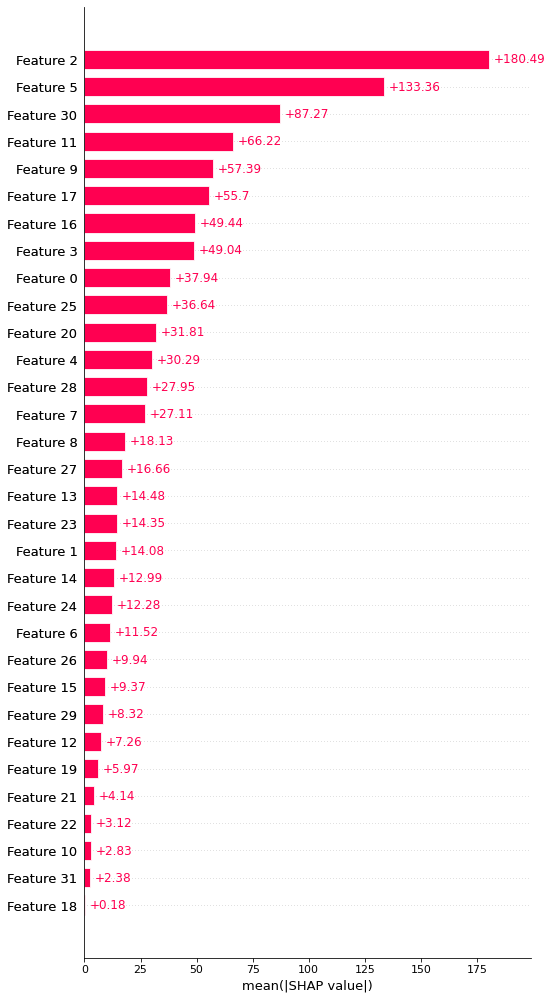

In [ ]:
## shap values
shap.plots.bar(shap_values,max_display = len(df[df.columns[df.columns != KPI_COL]].columns))

In [ ]:
vals= np.abs(shap_values.values).mean(axis = 0)

feature_importance = pd.DataFrame(list(zip(df[df.columns[df.columns != KPI_COL]].columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
2,x10lag0dreturns1_0adstock1_0,180.487380
5,x14lag0dreturns1_0adstock1_0,133.359195
30,Is_Q2Q3,87.265894
11,x29lag0dreturns0_6adstock1_0,66.215863
9,x27lag5dreturns1_0adstock1_0,57.385415
17,x35lag5dreturns0_6adstock1_0,55.700493
16,x34lag0dreturns0_9adstock1_0,49.437368
3,x11lag0dreturns0_9adstock1_0,49.041391
0,x6lag0dreturns0_6adstock1_0,37.936496
25,x43lag13dreturns0_6adstock1_0,36.636840


In [ ]:
# rescale the shap values to result in a scale rleative to total r-squared

sum_feature_imp = feature_importance.feature_importance_vals.sum()
scale_factor = reg.score(X,y)

feature_importance['attribution'] = feature_importance.feature_importance_vals / (sum_feature_imp / scale_factor)
feature_importance

,col_name,feature_importance_vals,attribution
2,x10lag0dreturns1_0adstock1_0,180.487380,0.148818
5,x14lag0dreturns1_0adstock1_0,133.359195,0.109959
30,Is_Q2Q3,87.265894,0.071954
11,x29lag0dreturns0_6adstock1_0,66.215863,0.054597
9,x27lag5dreturns1_0adstock1_0,57.385415,0.047316
17,x35lag5dreturns0_6adstock1_0,55.700493,0.045927
16,x34lag0dreturns0_9adstock1_0,49.437368,0.040763
3,x11lag0dreturns0_9adstock1_0,49.041391,0.040436
0,x6lag0dreturns0_6adstock1_0,37.936496,0.031280
25,x43lag13dreturns0_6adstock1_0,36.636840,0.030208


In [ ]:
round(feature_importance.attribution.sum(),2)

0.86

## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [ ]:
residuals = Y_prediction - y

###4.2) Linearity

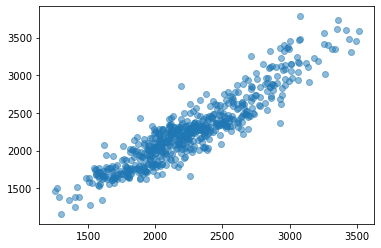

In [ ]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [ ]:
'''
Visually inspect the residuals to confirm normality
'''

'\nVisually inspect the residuals to confirm normality\n'

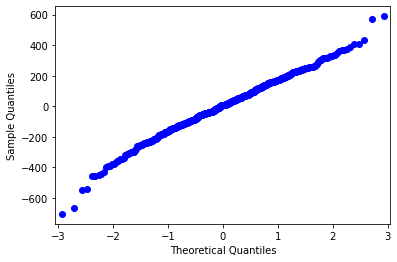

In [ ]:
fig = sm.qqplot(residuals)

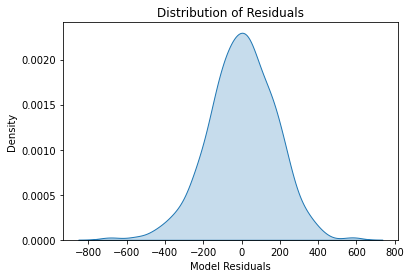

In [ ]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Absence of Multicollinearity

Tested and checked during data processing stage

###4.5) Homoscedasticity


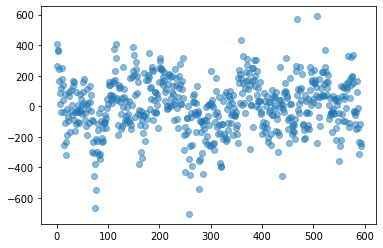

In [ ]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()

###4.6) Residual Autocorrelation Check

In [ ]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the 
model residuals
'''

dw = durbin_watson(residuals)
print('Durbin-Watson',dw)

In [ ]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')
